In [ ]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
from scipy.optimize import curve_fit
from scipy.special import factorial

from itertools import groupby

import importlib
import h5py

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [327]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:435: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:437: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV, $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:442: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py:444: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

## Impulse calibration before data taking

In [23]:
folder = r'/Volumes/LaCie/pulse_calibration/20241029_11e'
datasets = ['20241029_dg_11e_1v', '20241029_dg_11e_3v', '20241029_dg_11e_5v', '20241029_dg_11e_7v', '20241029_dg_11e_9v']
pulseamps = np.asarray([118, 389, 641, 919, 1175]) * 11/10

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241029_dg_11e_1v
20241029_dg_11e_3v
20241029_dg_11e_5v
20241029_dg_11e_7v
20241029_dg_11e_9v


In [24]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
# Take the average of 700 and 900 kev cases
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]

(0.0, 2500.0)

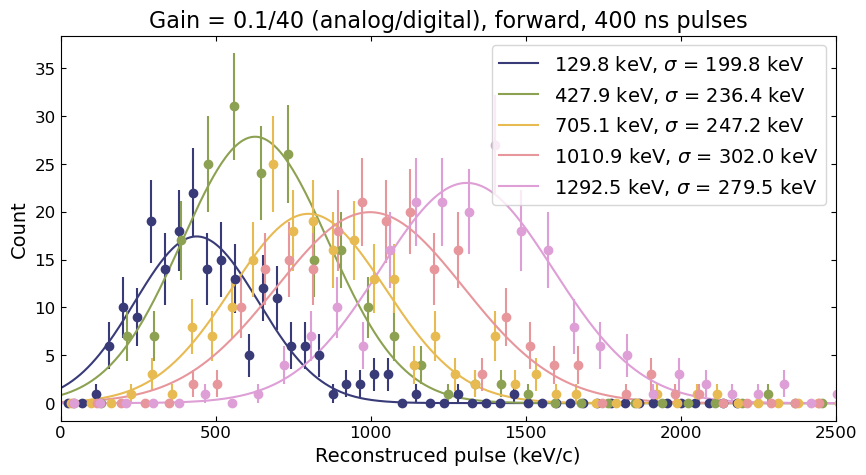

In [26]:
fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/40 (analog/digital), forward, 400 ns pulses')
ax.set_xlim(0, 2500)

In [27]:
unnormalized_amps_noise = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, True)

20241029_dg_11e_1v
20241029_dg_11e_3v
20241029_dg_11e_5v
20241029_dg_11e_7v
20241029_dg_11e_9v


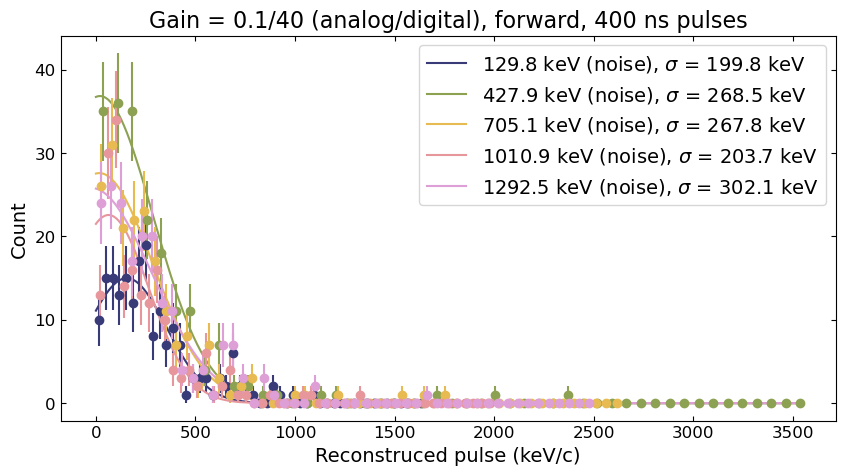

In [28]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus(unnormalized_amps_noise, True)
normalized_amps_noise = [amp * amp2kev for amp in unnormalized_amps_noise]

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps_noise, hhs_noise, bcs_noise, gps_noise, amp2kev=amp2kev, noise=True, title='Gain = 0.1/40 (analog/digital), forward, 400 ns pulses')


In [34]:
print(f'Amplitude to keV converstion factor: {amp2kev}')

Amplitude to keV converstion factor: 7182.659512852906


Figure out the proper search window for pulses

In [ ]:
file = r'/Volumes/LaCie/pulse_calibration/20241029_11e/20241029_dg_11e_9v_0.hdf5'
dtt, nn = utils.load_timestreams(file, ['D', 'G'])
fs = int(np.ceil(1 / dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 30000, 100000)
pulse_idx = utils.get_pulse_idx(dd, -0.5, False)

In [35]:
idx = pulse_idx[2]
window, f, f_lp, amp = utils.recon_pulse(idx, dtt, zz_bp, dd, False, None, 40000, 40000, 50, 30)

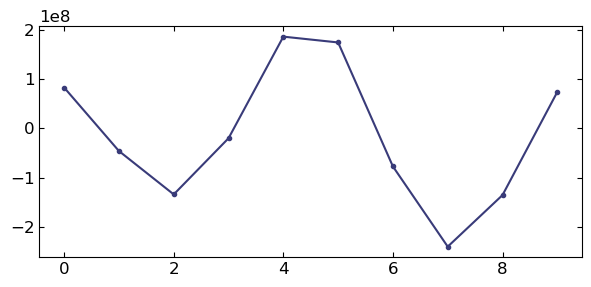

In [59]:
from scipy.signal import decimate

f_lp_ds = decimate(f_lp, 10)

plt.plot(f_lp_ds[4000:4010], '.-')

In [64]:
1 / 20e-6

49999.99999999999

## DM data

The sphere was unfortunately lost after about 6 hours of data taking. We will therefore only process the first 410 minutes of data.

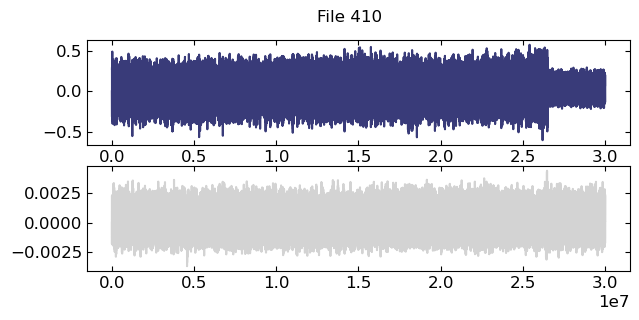

In [31]:
file = r'/Volumes/LaCie/dm_data/20241029_11e_long/20241029_df_11e_410.hdf5'
f = h5py.File(file, "r")

zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3
aa = f['data']['channel_f'][:] * f['data']['channel_f'].attrs['adc2mv'] / 1e3

fig, axes = plt.subplots(2, 1)
axes[0].plot(zz)
axes[1].plot(aa, color='lightgrey')
fig.suptitle('File 410')

f.close()


In [103]:
bc = None
hhs, good_dets, temps, charge_level = [], [], [], []
for i in range(410):
    f = h5py.File(f'/Users/yuhan/work/nanospheres/data/dm_data_processed/20241029_11e_long/20241029_df_11e_{i}_processed.hdf5', 'r')
    
    if bc is None:
        bc = f['data_processed'].attrs['bin_center_kev']
    
    hhs.append(f['data_processed']['histogram'][:])
    good_dets.append(f['data_processed']['good_detection'][:])
    temps.append(f['data_processed']['temp'][:])

    f.close()

In [104]:
temps = np.asarray(temps)
hhs = np.asarray(hhs)
good_dets = np.array(good_dets)

# q1, q2, q3 = np.quantile(temps.flatten(), [0.25, 0.5, 0.75])
# temp_thr = q2 + 1.5 * (q3 - q1)
temp_thr = 0.1

hh_cold = hhs[temps < temp_thr]
hh_cold_and_good = hhs[np.logical_and(temps < temp_thr, good_dets)]

In [196]:
hhs_time = hhs.shape[0] * hhs.shape[1] * 97 * 100e-6
hh_cold_and_good_time = hh_cold_and_good.shape[0] * 97 * 100e-6

Text(0.5, 1.0, 'Charged sphere (-11 e), 6 hour')

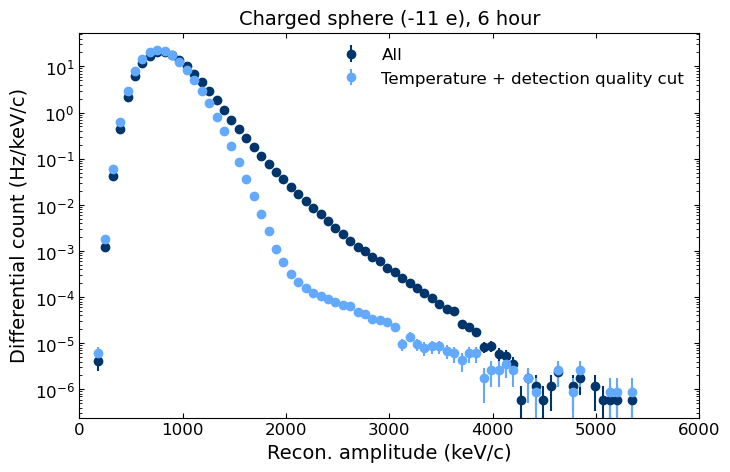

In [311]:
hh_all_sum = np.sum(np.sum(hhs, axis=0), axis=0)
hh_cold_sum = np.sum(hh_cold, axis=0)
hh_cold_and_good_sum = np.sum(hh_cold_and_good, axis=0)


hhs_scaling = hhs_time * (bc[1] - bc[0])
hh_cold_and_good_scaling = hh_cold_and_good_time * (bc[1] - bc[0])

plt.subplots(figsize=(8, 5))
plt.errorbar(bc, hh_all_sum/hhs_scaling, np.sqrt(hh_all_sum)/hhs_scaling, color=yale_colors[0], fmt='o', label='All')
# plt.errorbar(bc, hh_cold_sum, np.sqrt(hh_cold_sum), fmt='o')
plt.errorbar(bc, hh_cold_and_good_sum/hh_cold_and_good_scaling, np.sqrt(hh_cold_and_good_sum)/hh_cold_and_good_scaling, color=yale_colors[2], fmt='o', label='Temperature + detection quality cut')

plt.legend(frameon=False, fontsize=12)

plt.yscale('log')
plt.xlim(0, 6000)

plt.xlabel('Recon. amplitude (keV/c)')
plt.ylabel('Differential count (Hz/keV/c)')
plt.title('Charged sphere (-11 e), 6 hour')

In [173]:
cold_and_good_events_idx = []
cold_and_good_events_amp = []

threshold = 2000
bc_above_threshold = bc[bc > threshold]

for i, hh_file in enumerate(hhs):
    for j, hh in enumerate(hh_file):
        if np.sum(hh[bc > threshold]) == 1: # reject multiple events
            if temps[i, j] < temp_thr and good_dets[i, j]:
                    bin_idx = np.nonzero(hh[bc > threshold])
                    cold_and_good_events_amp.append(bc_above_threshold[bin_idx])
                    cold_and_good_events_idx.append(np.array([i, j]))

Text(0.5, 0.98, 'Events above 2 MeV/c')

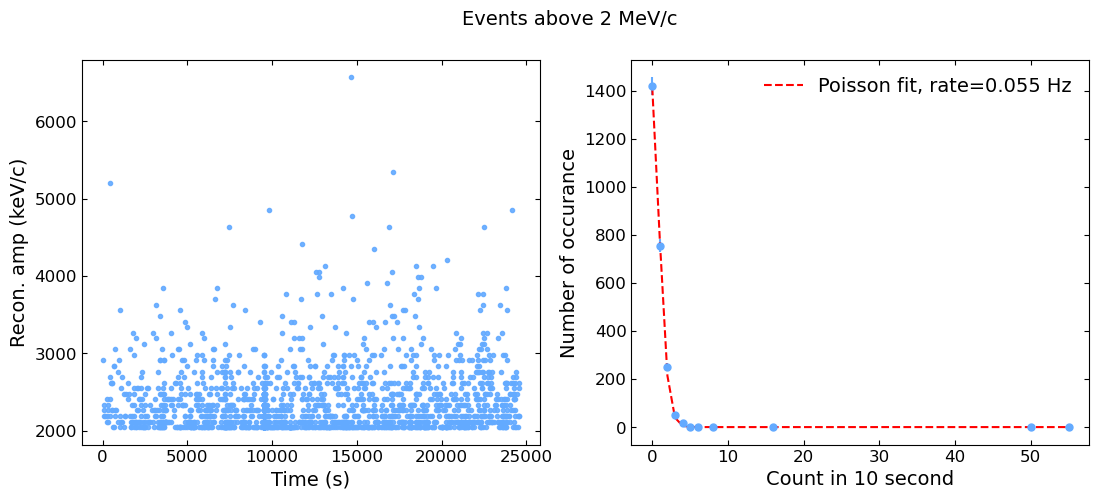

In [ ]:
time_all = np.empty_like(cold_and_good_events_amp)
for k, (i, j) in enumerate(cold_and_good_events_idx):
    time_all[k] = i * 60 + 10e-3 * j
    
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(time_all, cold_and_good_events_amp, '.', color=yale_colors[2], alpha=0.9)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Recon. amp (keV/c)')

def poisson(k, A, lam):
    return A * lam**k * np.exp(-1 * lam) / (factorial(k))

time_bins = np.arange(0, 25000, 10)
time_bcs = 0.5 * (time_bins[:-1] + time_bins[1:])
hh_time = np.histogram(time_all, bins=time_bins)[0]
values, counts = np.unique(hh_time, return_counts=True)

popt, pcov = curve_fit(poisson, values, counts, p0=[np.max(counts), 1])

axes[1].errorbar(values, counts, np.sqrt(counts), fmt='o', color=yale_colors[2], markersize=5)
axes[1].plot(values, poisson(values, *popt), 'r--', label=f'Poisson fit, rate={popt[1]/10:.3f} Hz')

# axes[1].set_yscale('log')
axes[1].legend(frameon=False, fontsize=14)
axes[1].set_xlabel('Count in 10 second')
axes[1].set_ylabel('Number of occurance')

fig.suptitle('Events above 2 MeV/c', fontsize=14)


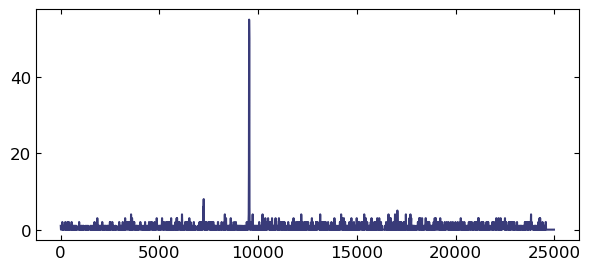

In [ ]:
plt.plot(time_bcs, hh_time)



Text(0, 0.5, 'Number of occurance')

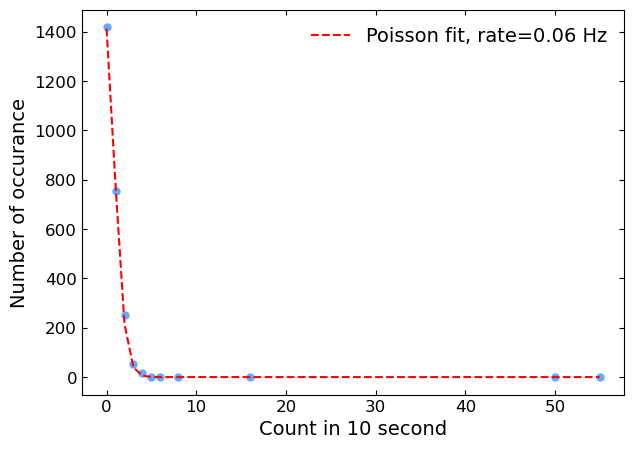

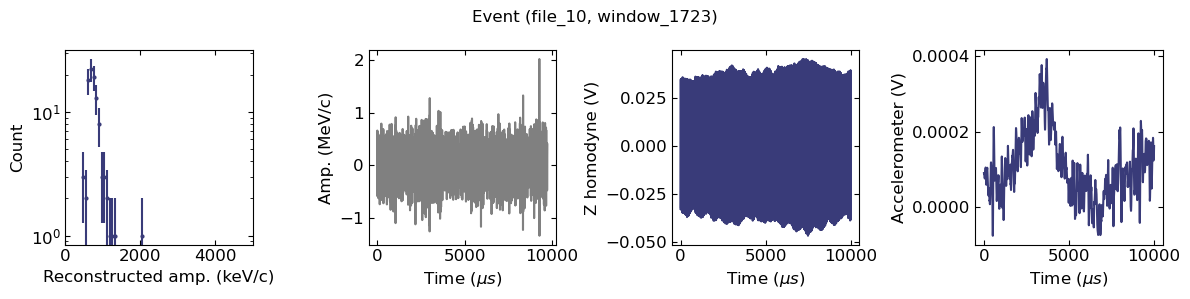

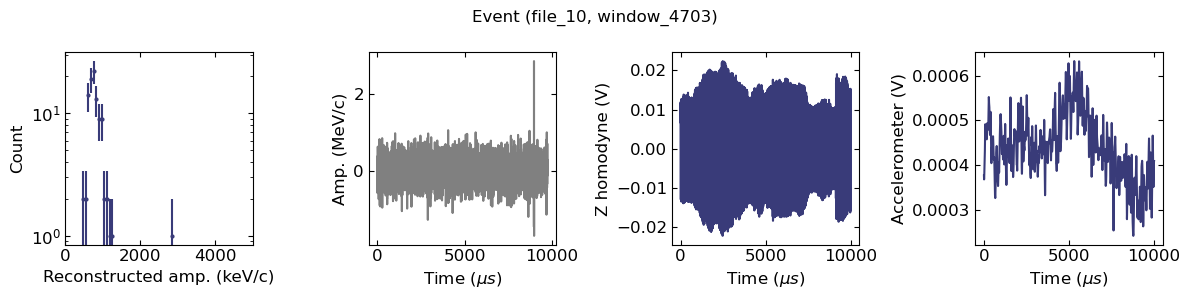

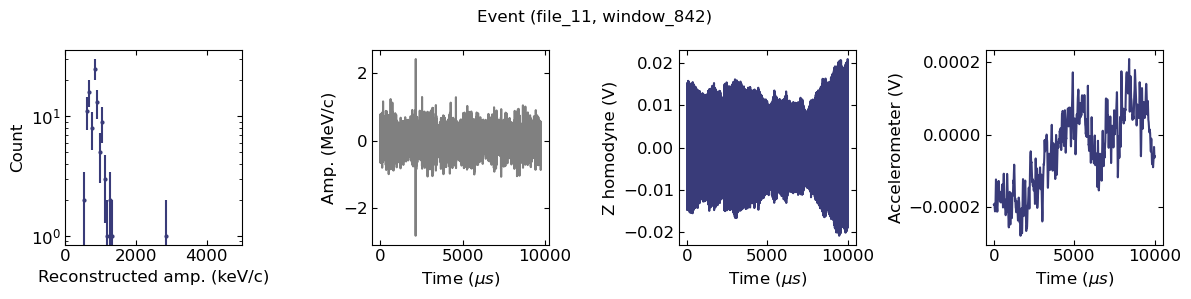

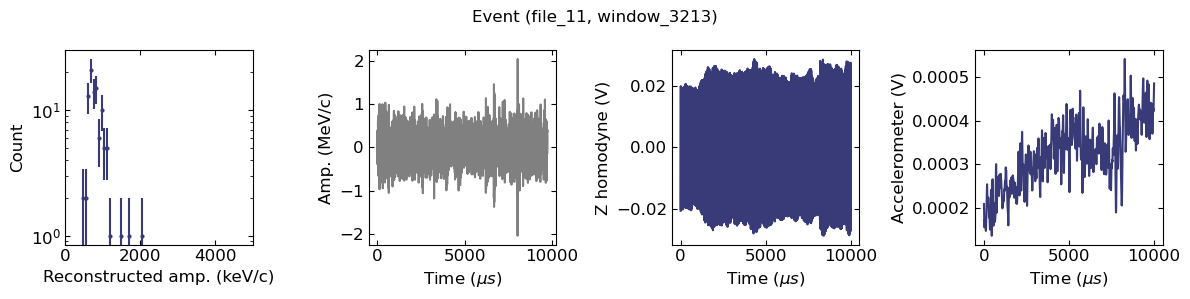

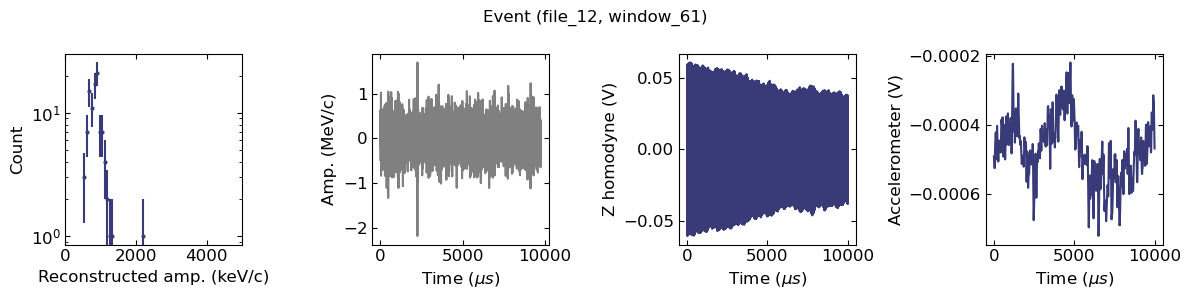

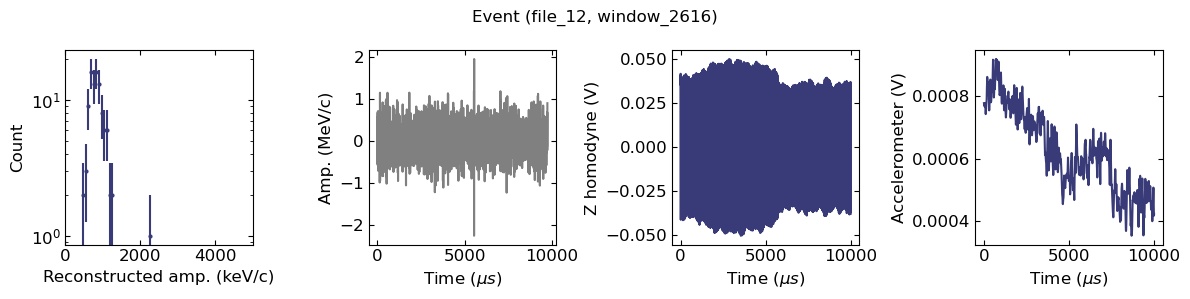

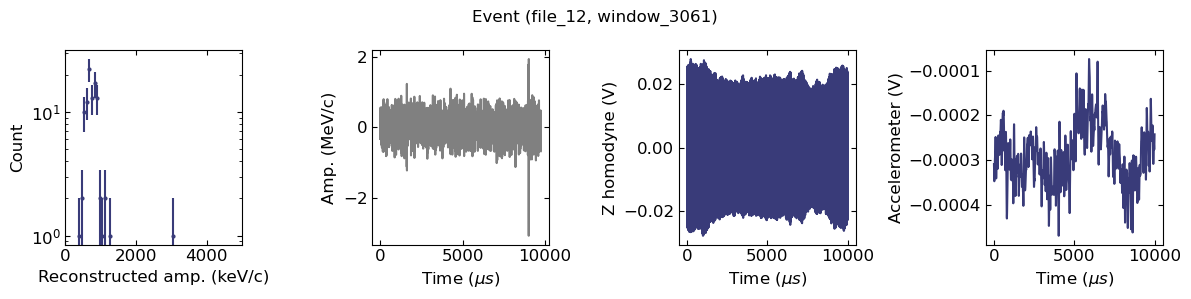

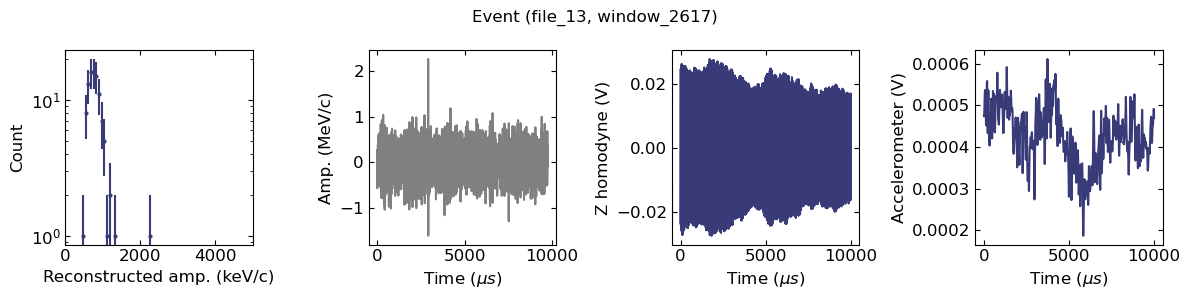

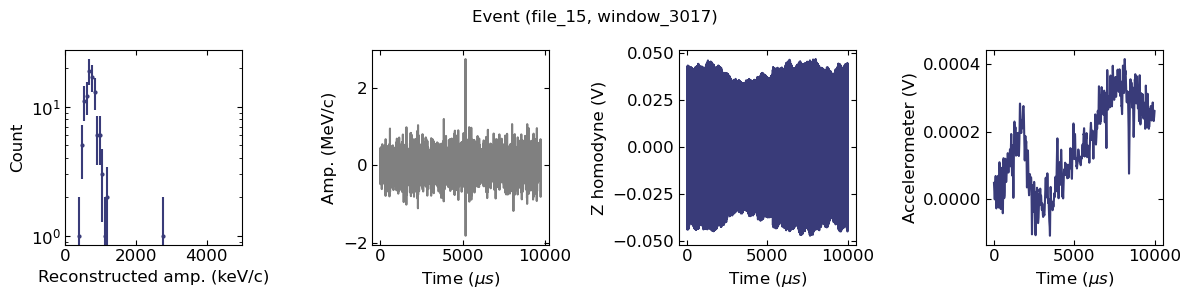

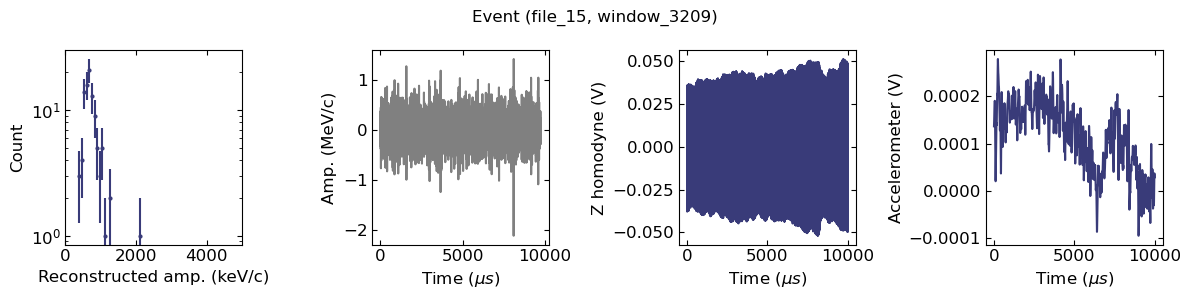

In [240]:
c_mv = 5.522e-08
amp2kev = 7182.659512852906

window_length = 5000
bins = np.arange(0, 5, 0.01)
bc = 0.5 * (bins[:-1] + bins[1:]) * amp2kev

data_dir = r'/Volumes/LaCie/dm_data/20241029_11e_long'
combined_path = os.path.join(data_dir, '*.hdf5')
data_files = glob.glob(combined_path)

for i, j in cold_and_good_events_idx[20:30]:
    _, _, _, _, _ = utils.plot_hist_events(data_files, i, j, window_length, bins, bc, c_mv, amp2kev)

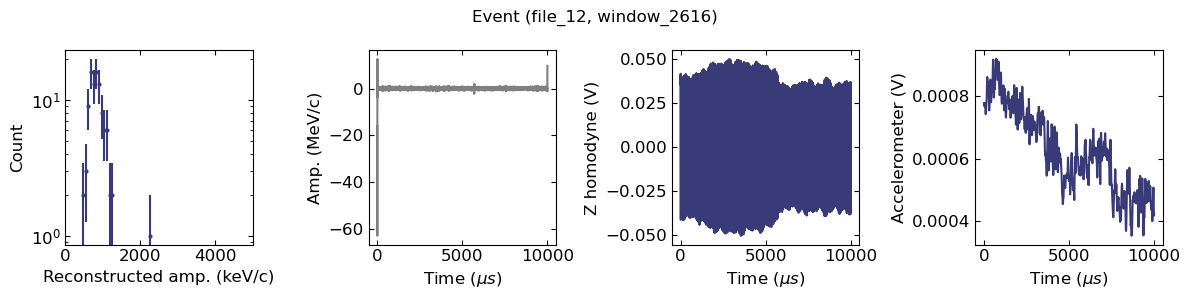

In [328]:
i, j = 12, 2616
amp_lp, _, zz_bp, fig, axes = utils.plot_hist_events(data_files, i, j, window_length, bins, bc, c_mv, amp2kev)

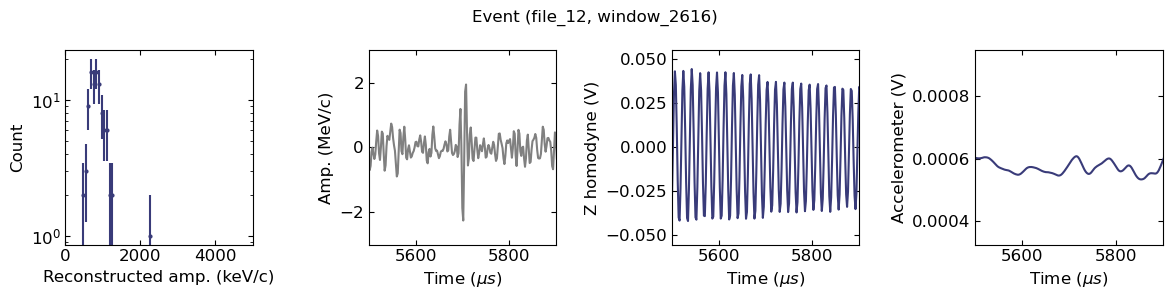

In [330]:
axes[1].set_xlim(2*(2750), 2*(2950))
axes[1].set_ylim(-3, 3)
axes[2].set_xlim(2*2750, 2*2950)
axes[3].set_xlim(2*2750, 2*2950)

fig


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_12937/1604794588.py:10: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_xlabel('Time ($\mu$s)')


Text(0, 0.5, 'Recon. amp (keV/c)')

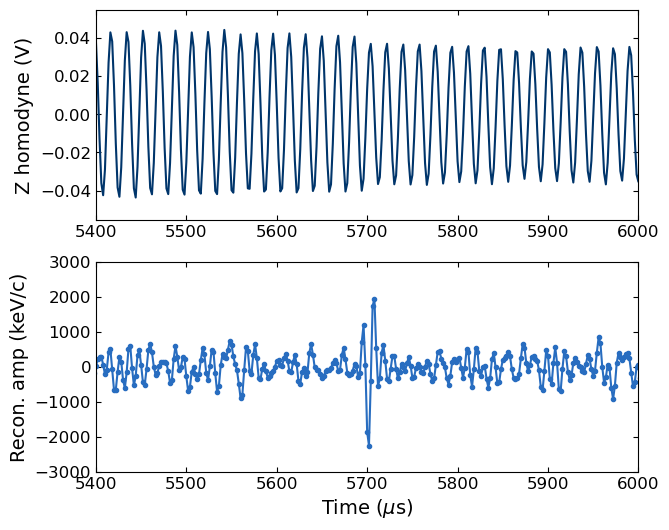

In [313]:
fig, axes = plt.subplots(2, 1, figsize=(7, 6))

axes[0].plot(2*np.arange(zz_bp.size), zz_bp, yale_colors[0])
axes[0].set_xlim(2*2700, 2*3000)
axes[0].set_ylabel('Z homodyne (V)')

axes[1].plot(2*np.arange(amp_lp.size), amp_lp*amp2kev, '.-', color=yale_colors[1])
axes[1].set_xlim(2*2700, 2*3000)
axes[1].set_ylim(-3000, 3000)
axes[1].set_xlabel('Time ($\mu$s)')
axes[1].set_ylabel('Recon. amp (keV/c)')


(-3000.0, 3000.0)

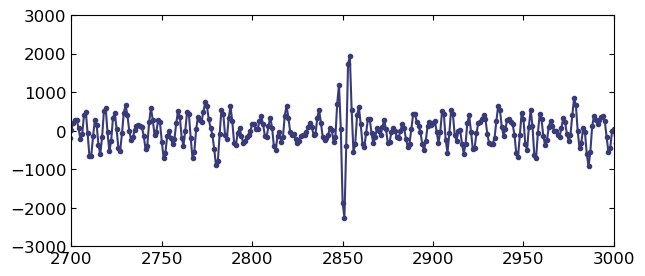